In [130]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import KFold
from sklearn.grid_search import GridSearchCV
from xgboost import XGBRegressor
from xgboost import plot_importance
%matplotlib inline

In [131]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [132]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


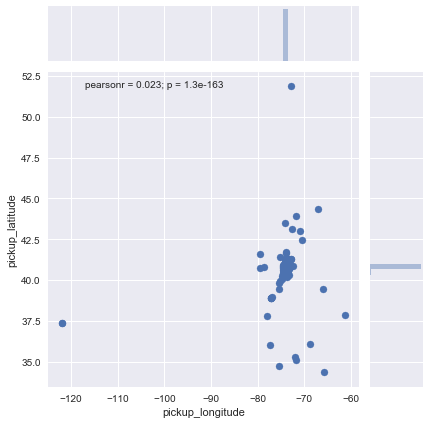

In [133]:
sns.jointplot(x="pickup_longitude", y="pickup_latitude", data=train);

In [134]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [135]:
test.shape

(625134, 9)

In [136]:
m = np.mean(train['trip_duration'])
s = np.std(train['trip_duration'])
train = train[(train['trip_duration'] <= m + 2*s) & (train['trip_duration'] >= m -2*s)]
train = train[(train['pickup_longitude'] > -74.023822) & (train['pickup_latitude'] < 40.886345) & (train['pickup_longitude'] < -73.901599) & (train['pickup_latitude'] > 40.698160)]

In [168]:
test_id = test['id']

In [137]:
train['source'] = 'train'
test['source'] = 'test'
df = pd.concat([train, test], ignore_index=True)

In [138]:
#sns.jointplot(x = 'pickup_longitude', y = 'pickup_latitude', data = df, s = 4)

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1990557 entries, 0 to 1990556
Data columns (total 12 columns):
dropoff_datetime      object
dropoff_latitude      float64
dropoff_longitude     float64
id                    object
passenger_count       int64
pickup_datetime       object
pickup_latitude       float64
pickup_longitude      float64
source                object
store_and_fwd_flag    object
trip_duration         float64
vendor_id             int64
dtypes: float64(5), int64(2), object(5)
memory usage: 182.2+ MB


In [140]:
df.describe()

,dropoff_latitude,dropoff_longitude,passenger_count,pickup_latitude,pickup_longitude,trip_duration,vendor_id
count,1.990557e+06,1.990557e+06,1.990557e+06,1.990557e+06,1.990557e+06,1.365423e+06,1.990557e+06
mean,4.075267e+01,-7.397441e+01,1.661832e+00,4.075285e+01,-7.397868e+01,7.723499e+02,1.533578e+00
std,3.258285e-02,4.933976e-02,1.312092e+00,2.481170e-02,4.366096e-02,5.596175e+02,4.988713e-01
min,3.639812e+01,-1.219333e+02,0.000000e+00,3.738959e+01,-1.219331e+02,1.000000e+00,1.000000e+00
25%,4.073701e+01,-7.399142e+01,1.000000e+00,4.073860e+01,-7.399226e+01,3.860000e+02,1.000000e+00
50%,4.075495e+01,-7.397997e+01,1.000000e+00,4.075438e+01,-7.398222e+01,6.350000e+02,2.000000e+00
75%,4.077022e+01,-7.396364e+01,2.000000e+00,4.076783e+01,-7.396950e+01,1.004000e+03,2.000000e+00
max,4.885760e+01,-6.749680e+01,9.000000e+00,4.281494e+01,-6.924892e+01,1.141100e+04,2.000000e+00


In [141]:
df.head()

,dropoff_datetime,dropoff_latitude,dropoff_longitude,id,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,source,store_and_fwd_flag,trip_duration,vendor_id
0,2016-03-14 17:32:30,40.765602,-73.964630,id2875421,1,2016-03-14 17:24:55,40.767937,-73.982155,train,N,455.0,2
1,2016-06-12 00:54:38,40.731152,-73.999481,id2377394,1,2016-06-12 00:43:35,40.738564,-73.980415,train,N,663.0,1
2,2016-01-19 12:10:48,40.710087,-74.005333,id3858529,1,2016-01-19 11:35:24,40.763939,-73.979027,train,N,2124.0,2
3,2016-04-06 19:39:40,40.706718,-74.012268,id3504673,1,2016-04-06 19:32:31,40.719971,-74.010040,train,N,429.0,2
4,2016-03-26 13:38:10,40.782520,-73.972923,id2181028,1,2016-03-26 13:30:55,40.793209,-73.973053,train,N,435.0,2


In [142]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['pickup_month'] = df['pickup_datetime'].dt.month
df['pickup_day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['pickup_day'] = df['pickup_datetime'].dt.day
df['pickup_hour'] = df['pickup_datetime'].dt.hour

In [143]:
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

In [144]:
df['dropoff_month'] = df['dropoff_datetime'].dt.month
df['dropoff_day_of_week'] = df['dropoff_datetime'].dt.dayofweek
df['dropoff_day'] = df['dropoff_datetime'].dt.day
df['dropoff_hour'] = df['dropoff_datetime'].dt.hour

In [145]:
df.head()

,dropoff_datetime,dropoff_latitude,dropoff_longitude,id,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,source,store_and_fwd_flag,trip_duration,vendor_id,pickup_month,pickup_day_of_week,pickup_day,pickup_hour,dropoff_month,dropoff_day_of_week,dropoff_day,dropoff_hour
0,2016-03-14 17:32:30,40.765602,-73.964630,id2875421,1,2016-03-14 17:24:55,40.767937,-73.982155,train,N,455.0,2,3,0,14,17,3.0,0.0,14.0,17.0
1,2016-06-12 00:54:38,40.731152,-73.999481,id2377394,1,2016-06-12 00:43:35,40.738564,-73.980415,train,N,663.0,1,6,6,12,0,6.0,6.0,12.0,0.0
2,2016-01-19 12:10:48,40.710087,-74.005333,id3858529,1,2016-01-19 11:35:24,40.763939,-73.979027,train,N,2124.0,2,1,1,19,11,1.0,1.0,19.0,12.0
3,2016-04-06 19:39:40,40.706718,-74.012268,id3504673,1,2016-04-06 19:32:31,40.719971,-74.010040,train,N,429.0,2,4,2,6,19,4.0,2.0,6.0,19.0
4,2016-03-26 13:38:10,40.782520,-73.972923,id2181028,1,2016-03-26 13:30:55,40.793209,-73.973053,train,N,435.0,2,3,5,26,13,3.0,5.0,26.0,13.0


In [146]:
coords = np.vstack((df[['pickup_latitude', 'pickup_longitude']],
                    df[['dropoff_latitude', 'dropoff_longitude']]))
sample_ind = np.random.permutation(len(coords))[:1000000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=20000).fit(coords[sample_ind])

In [147]:
df['pickup_cluster'] = kmeans.predict(df[['pickup_latitude', 'pickup_longitude']])
df['dropoff_cluster'] = kmeans.predict(df[['dropoff_latitude', 'dropoff_longitude']])

In [148]:
df.head()

,dropoff_datetime,dropoff_latitude,dropoff_longitude,id,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,source,store_and_fwd_flag,...,pickup_month,pickup_day_of_week,pickup_day,pickup_hour,dropoff_month,dropoff_day_of_week,dropoff_day,dropoff_hour,pickup_cluster,dropoff_cluster
0,2016-03-14 17:32:30,40.765602,-73.964630,id2875421,1,2016-03-14 17:24:55,40.767937,-73.982155,train,N,...,3,0,14,17,3.0,0.0,14.0,17.0,14,43
1,2016-06-12 00:54:38,40.731152,-73.999481,id2377394,1,2016-06-12 00:43:35,40.738564,-73.980415,train,N,...,6,6,12,0,6.0,6.0,12.0,0.0,62,82
2,2016-01-19 12:10:48,40.710087,-74.005333,id3858529,1,2016-01-19 11:35:24,40.763939,-73.979027,train,N,...,1,1,19,11,1.0,1.0,19.0,12.0,91,4
3,2016-04-06 19:39:40,40.706718,-74.012268,id3504673,1,2016-04-06 19:32:31,40.719971,-74.010040,train,N,...,4,2,6,19,4.0,2.0,6.0,19.0,81,63
4,2016-03-26 13:38:10,40.782520,-73.972923,id2181028,1,2016-03-26 13:30:55,40.793209,-73.973053,train,N,...,3,5,26,13,3.0,5.0,26.0,13.0,84,78


In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1990557 entries, 0 to 1990556
Data columns (total 22 columns):
dropoff_datetime       datetime64[ns]
dropoff_latitude       float64
dropoff_longitude      float64
id                     object
passenger_count        int64
pickup_datetime        datetime64[ns]
pickup_latitude        float64
pickup_longitude       float64
source                 object
store_and_fwd_flag     object
trip_duration          float64
vendor_id              int64
pickup_month           int64
pickup_day_of_week     int64
pickup_day             int64
pickup_hour            int64
dropoff_month          float64
dropoff_day_of_week    float64
dropoff_day            float64
dropoff_hour           float64
pickup_cluster         int32
dropoff_cluster        int32
dtypes: datetime64[ns](2), float64(9), int32(2), int64(6), object(3)
memory usage: 318.9+ MB


In [150]:
df = df.drop(['id', 'store_and_fwd_flag'], axis = 1)

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1990557 entries, 0 to 1990556
Data columns (total 20 columns):
dropoff_datetime       datetime64[ns]
dropoff_latitude       float64
dropoff_longitude      float64
passenger_count        int64
pickup_datetime        datetime64[ns]
pickup_latitude        float64
pickup_longitude       float64
source                 object
trip_duration          float64
vendor_id              int64
pickup_month           int64
pickup_day_of_week     int64
pickup_day             int64
pickup_hour            int64
dropoff_month          float64
dropoff_day_of_week    float64
dropoff_day            float64
dropoff_hour           float64
pickup_cluster         int32
dropoff_cluster        int32
dtypes: datetime64[ns](2), float64(9), int32(2), int64(6), object(1)
memory usage: 288.5+ MB


In [152]:
#calculate the distance between two coordinates
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [153]:
df['distance'] = haversine_np(df['pickup_longitude'], df['pickup_latitude'], df['dropoff_longitude'], df['dropoff_latitude'])

# Deal with categorical values

In [154]:
#use different dataframe to store numerical values
pickup_month = pd.get_dummies(df['pickup_month'], prefix='pickup_month')
pickup_hour = pd.get_dummies(df['pickup_hour'], prefix='pickup_hour')
pickup_dayofweek = pd.get_dummies(df['pickup_day_of_week'], prefix='pickup_day_of_week')
pickup_day = pd.get_dummies(df['pickup_day'], prefix='pickup_day')
dropoff_month = pd.get_dummies(df['dropoff_month'], prefix='dropoff_month')
dropoff_hour = pd.get_dummies(df['dropoff_hour'], prefix='dropoff_hour')
dropoff_dayofweek = pd.get_dummies(df['dropoff_day_of_week'], prefix='dropoff_day_of_week')
dropoff_day = pd.get_dummies(df['dropoff_day'], prefix='dropoff_day')

In [155]:
pickup_cluster = pd.get_dummies(df['pickup_cluster'], prefix='pickup_cluster')
dropoff_cluster = pd.get_dummies(df['dropoff_cluster'], prefix='dropoff_cluster')

In [156]:
passenger_count = pd.get_dummies(df['passenger_count'], prefix='passenger_count')
vendor_id = pd.get_dummies(df['vendor_id'], prefix='vendor_id')

In [157]:
#drop old categorical columns and concat new numerical columns
df_numerical = df.drop(['pickup_cluster', 'pickup_day', 'pickup_day_of_week', 'pickup_hour', 'pickup_month', 'dropoff_cluster', 'dropoff_day', 'dropoff_day_of_week', 'dropoff_hour', 'dropoff_month', 'passenger_count', 'vendor_id'], axis = 1)
df_numerical = pd.concat([df_numerical, pickup_month, pickup_day, pickup_dayofweek, pickup_hour, pickup_cluster, dropoff_month, dropoff_day, dropoff_dayofweek, dropoff_hour, dropoff_cluster, passenger_count, vendor_id], axis = 1)

In [158]:
df_numerical = df_numerical.drop(['pickup_datetime', 'dropoff_datetime'], axis = 1)
df_numerical.head()

,dropoff_latitude,dropoff_longitude,pickup_latitude,pickup_longitude,source,trip_duration,distance,pickup_month_1,pickup_month_2,pickup_month_3,...,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_8,passenger_count_9,vendor_id_1,vendor_id_2
0,40.765602,-73.964630,40.767937,-73.982155,train,455.0,1.497580,0,0,1,...,1,0,0,0,0,0,0,0,0,1
1,40.731152,-73.999481,40.738564,-73.980415,train,663.0,1.804374,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,40.710087,-74.005333,40.763939,-73.979027,train,2124.0,6.381090,1,0,0,...,1,0,0,0,0,0,0,0,0,1
3,40.706718,-74.012268,40.719971,-74.010040,train,429.0,1.484566,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,40.782520,-73.972923,40.793209,-73.973053,train,435.0,1.187842,0,0,1,...,1,0,0,0,0,0,0,0,0,1


In [159]:
#sns.heatmap(df['pickup_cluster'])

# Seperate the dataframe back to training set and test set

In [160]:
train_numerical = df_numerical[df_numerical['source'] == 'train']
test_numerical = df_numerical[df_numerical['source'] == 'test']

In [161]:
# train_numerical.to_csv('train_numerical000.csv', index=False)
# test_numerical.to_csv('test_numerical000.csv', index=False)

In [125]:
test_numerical.columns

Index(['dropoff_latitude', 'dropoff_longitude', 'pickup_latitude',
       'pickup_longitude', 'source', 'trip_duration', 'distance',
       'pickup_month_1', 'pickup_month_2', 'pickup_month_3',
       ...
       'passenger_count_1', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
       'passenger_count_8', 'passenger_count_9', 'vendor_id_1', 'vendor_id_2'],
      dtype='object', length=342)

In [162]:
X_train = train_numerical.drop(['trip_duration', 'source'], axis = 1)
y_train = train_numerical['trip_duration']

In [35]:
y_train.shape

(1365409,)

In [36]:
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

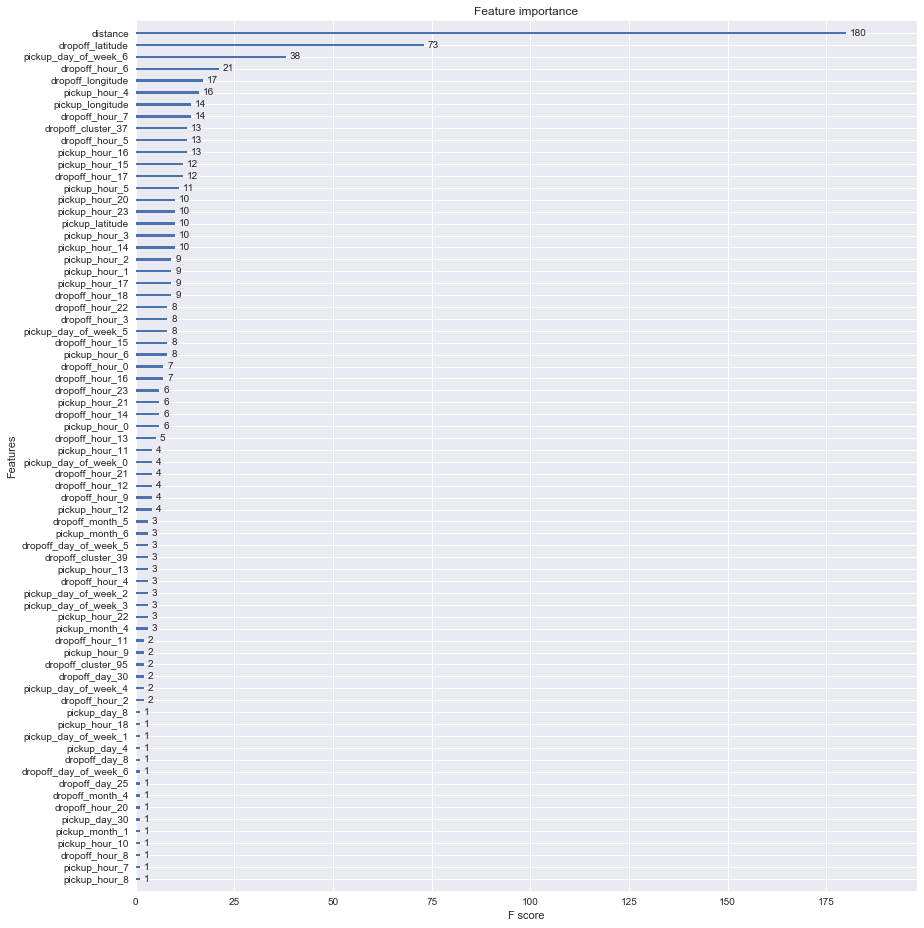

In [37]:
ax = plot_importance(model)
fig = ax.figure
fig.set_size_inches(14, 16)

# Choose features according to feature_importance_, then fit and predict

In [126]:
features = ['distance', 'dropoff_latitude', 'pickup_day_of_week_6', 'dropoff_longitude']
target = ['trip_duration']

In [127]:
model.fit(X_train[features], y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [56]:
#df_numerical['source'].value_counts()

train    1365409
Name: source, dtype: int64

In [163]:
predictions = model.predict(test_numerical[features])

In [176]:
predictions = np.absolute(predictions)

In [177]:
d = {'id': test_id, 'trip_duration': predictions}

In [178]:
submit = pd.DataFrame(data = d)

In [179]:
submit.to_csv("submit0822.csv", index=False)

In [180]:
#submit[submit['trip_duration'] < 0]

In [181]:
#test[test['id'] == 'id0466318']